In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/netflix-appetency/sample_submission.csv
/kaggle/input/netflix-appetency/train.csv
/kaggle/input/netflix-appetency/test.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
color=sns.color_palette()
import matplotlib as mpl
from sklearn import preprocessing as pp
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_curve,average_precision_score
from sklearn.metrics import roc_curve,auc,roc_auc_score
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb

In [3]:
df_train=pd.read_csv("../input/netflix-appetency/train.csv")
df_test=pd.read_csv("../input/netflix-appetency/test.csv")
sample=pd.read_csv("../input/netflix-appetency/sample_submission.csv")

In [4]:
train_idx=df_train[['id']]
train_idx.head(20)

,id
0,0
1,1
2,2
3,3
4,4
5,6
6,8
7,10
8,12
9,13


In [5]:
test_idx=df_test[['id']]
test_idx.head(20)

,id
0,5
1,7
2,9
3,11
4,14
5,15
6,19
7,21
8,25
9,29


In [6]:
target=df_train[['target']]
target

,target
0,0
1,0
2,0
3,0
4,1
...,...
69995,0
69996,0
69997,0
69998,0


<AxesSubplot:xlabel='target'>

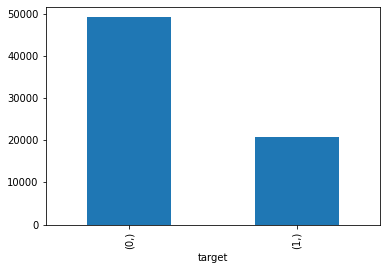

In [7]:
target.value_counts().plot(kind='bar')

In [8]:
train=df_train.drop('id',axis=1)
train

,target,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_497,feature_498,feature_499,feature_500,feature_501,feature_502,feature_503,feature_504,feature_505,feature_506
0,0,C0,C0,C1,C5,C11,37.560,54.756667,54.756667,35.83,...,0,0,0,0,0,0,0,0,0,0
1,0,C0,C0,C3,C5,C1,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2,0,C0,C0,C3,C5,C2,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
3,0,C0,C0,C1,C5,C1,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
4,1,C0,C0,C3,C3,C11,37.480,37.480000,37.161333,35.75,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,0,C0,C0,C3,C1,C11,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
69996,0,C0,C0,C5,C5,C2,39.398,35.022000,45.645000,30.83,...,0,0,0,0,0,0,0,0,0,0
69997,0,C0,C0,C3,C2,C11,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
69998,0,C0,C0,C1,C5,C1,30.060,35.765000,35.765000,30.06,...,-99,0,-99,0,99,0,99,-99,0,99


In [9]:
test=df_test.drop('id',axis=1)
test

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_497,feature_498,feature_499,feature_500,feature_501,feature_502,feature_503,feature_504,feature_505,feature_506
0,C0,C0,C0,C5,C2,37.638,36.361667,42.688333,31.66,31.660000,...,0,0,0,0,0,0,0,0,0,0
1,C0,C0,C3,C5,C11,32.540,32.540000,39.403333,30.82,30.820000,...,0,0,0,0,0,0,0,0,0,0
2,C0,C0,C1,C5,C1,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
3,C0,C0,C3,C5,C2,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
4,C0,C0,C1,C5,C10,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,C0,C0,C3,C5,C7,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
29996,C0,C0,C2,C5,C1,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
29997,C0,C0,C4,C2,C2,44.320,44.320000,43.959000,42.49,42.490000,...,0,0,0,0,0,0,0,0,0,0
29998,C0,C0,C0,C5,C11,45.660,44.223333,42.346667,44.13,42.693333,...,0,0,0,0,0,0,0,0,0,0


In [10]:
train.shape

(70000, 508)

In [11]:
test.shape

(30000, 507)

In [12]:
train.dtypes.value_counts()

int64      273
float64    143
object      92
dtype: int64

In [13]:
test.dtypes.value_counts()

int64      272
float64    143
object      92
dtype: int64

In [14]:
train.isnull().sum(1).sort_values()

46591     5
50318     5
39693     5
49511     5
64650     5
         ..
23937    69
38846    69
68996    69
40919    69
58868    69
Length: 70000, dtype: int64

In [15]:
train.isnull().sum(axis=1)

0        17
1        26
2        25
3        23
4         6
         ..
69995    17
69996    14
69997    16
69998    16
69999    46
Length: 70000, dtype: int64

In [16]:
NanColumnsTrain=train.columns[train.isna().any()].tolist()
NanColumnsTrain

['feature_5',
 'feature_6',
 'feature_7',
 'feature_8',
 'feature_9',
 'feature_10',
 'feature_11',
 'feature_12',
 'feature_13',
 'feature_35',
 'feature_36',
 'feature_37',
 'feature_38',
 'feature_39',
 'feature_40',
 'feature_60',
 'feature_67',
 'feature_68',
 'feature_75',
 'feature_76',
 'feature_81',
 'feature_83',
 'feature_84',
 'feature_85',
 'feature_86',
 'feature_88',
 'feature_89',
 'feature_90',
 'feature_91',
 'feature_92',
 'feature_93',
 'feature_94',
 'feature_95',
 'feature_96',
 'feature_128',
 'feature_129',
 'feature_130',
 'feature_131',
 'feature_132',
 'feature_153',
 'feature_154',
 'feature_155',
 'feature_156',
 'feature_157',
 'feature_158',
 'feature_159',
 'feature_160',
 'feature_161',
 'feature_162',
 'feature_172',
 'feature_191',
 'feature_192',
 'feature_193',
 'feature_194',
 'feature_195',
 'feature_196',
 'feature_197',
 'feature_198',
 'feature_200',
 'feature_201',
 'feature_202',
 'feature_203',
 'feature_204',
 'feature_206',
 'feature_207',

In [17]:
len(NanColumnsTrain)

73

In [18]:
NanColumnsTest=test.columns[test.isna().any()].tolist()
NanColumnsTest

['feature_5',
 'feature_6',
 'feature_7',
 'feature_8',
 'feature_9',
 'feature_10',
 'feature_11',
 'feature_12',
 'feature_13',
 'feature_35',
 'feature_36',
 'feature_37',
 'feature_38',
 'feature_39',
 'feature_40',
 'feature_60',
 'feature_67',
 'feature_68',
 'feature_75',
 'feature_76',
 'feature_81',
 'feature_83',
 'feature_84',
 'feature_85',
 'feature_86',
 'feature_88',
 'feature_89',
 'feature_90',
 'feature_91',
 'feature_92',
 'feature_93',
 'feature_94',
 'feature_95',
 'feature_96',
 'feature_128',
 'feature_129',
 'feature_130',
 'feature_131',
 'feature_132',
 'feature_153',
 'feature_154',
 'feature_155',
 'feature_156',
 'feature_157',
 'feature_158',
 'feature_159',
 'feature_160',
 'feature_161',
 'feature_162',
 'feature_172',
 'feature_191',
 'feature_192',
 'feature_193',
 'feature_194',
 'feature_195',
 'feature_196',
 'feature_197',
 'feature_198',
 'feature_200',
 'feature_201',
 'feature_202',
 'feature_203',
 'feature_204',
 'feature_206',
 'feature_207',

In [19]:
len(NanColumnsTest)

73

In [20]:
train[train.columns[train.isnull().any()]].isnull().sum()

feature_5      44576
feature_6      43611
feature_7      42208
feature_8      44576
feature_9      43611
               ...  
feature_256     1452
feature_257     1937
feature_258     1601
feature_259     1452
feature_260     1452
Length: 73, dtype: int64

In [21]:
train[train.columns[train.isnull().any()]].isnull().sum() * 100 / train.shape[0]

feature_5      63.680000
feature_6      62.301429
feature_7      60.297143
feature_8      63.680000
feature_9      62.301429
                 ...    
feature_256     2.074286
feature_257     2.767143
feature_258     2.287143
feature_259     2.074286
feature_260     2.074286
Length: 73, dtype: float64

In [22]:
print("No. of columns containing null values")
print(len(train.columns[train.isna().any()]))

print("No. of columns not containing null values")
print(len(train.columns[train.notna().all()]))

print("Total no. of columns in the dataframe")
print(len(train.columns))

No. of columns containing null values
73
No. of columns not containing null values
435
Total no. of columns in the dataframe
508


In [23]:
import matplotlib.pyplot as plt
def plot_nas(df: pd.DataFrame):
    if df.isnull().sum().sum() != 0:
        na_df = (df.isnull().sum() / len(df)) * 100      
        na_df = na_df.drop(na_df[na_df == 0].index).sort_values(ascending=False)
        missing_data = pd.DataFrame({'Missing Ratio %' :na_df})
        plot_width, plot_height = (16,18)
        plt.rcParams['figure.figsize'] = (plot_width,plot_height)
        missing_data.plot(kind = "barh")
        
        plt.show()
    else:
        print('No NAs found')


In [24]:
train['feature_193'].isna().sum()

70000

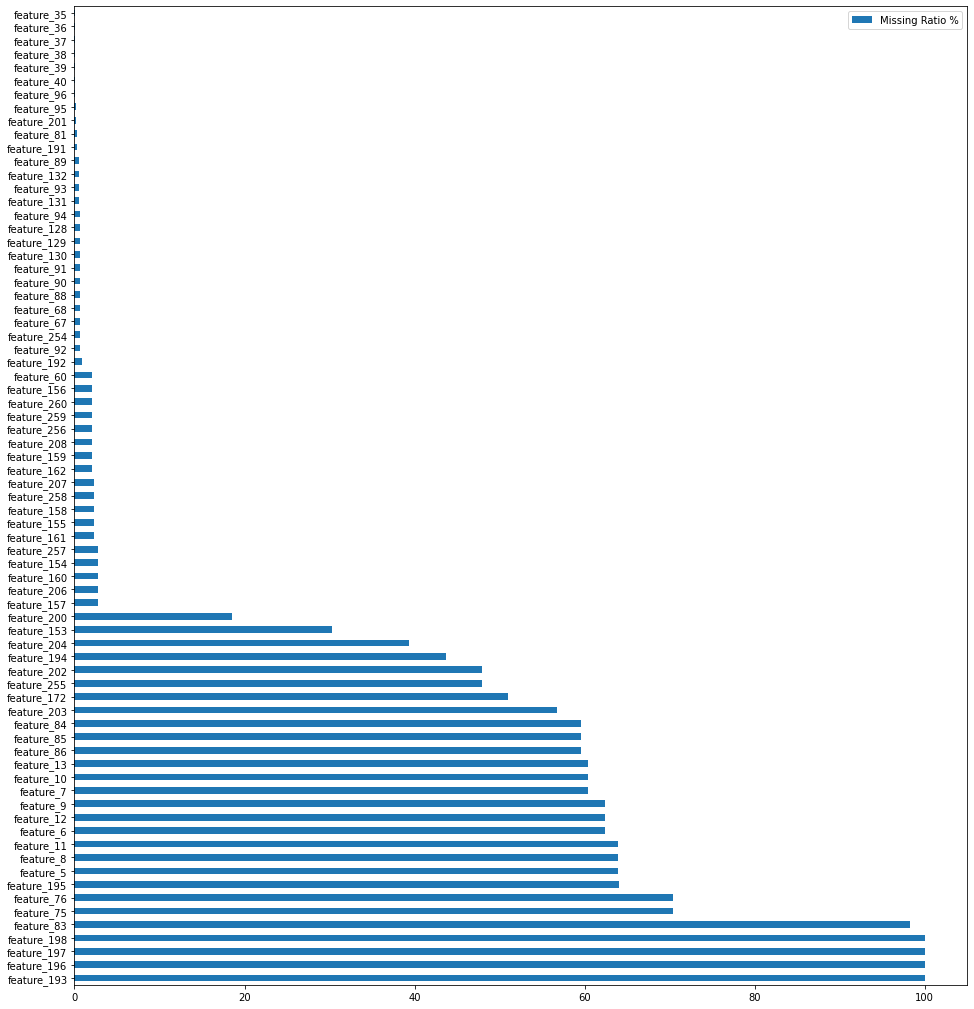

In [25]:
plot_nas(test)

In [26]:
train.dtypes.value_counts()

int64      273
float64    143
object      92
dtype: int64

In [27]:
test.dtypes.value_counts()

int64      272
float64    143
object      92
dtype: int64

In [28]:
intColumns=list(train.select_dtypes(include=['int64']).columns)
intColumns

['target',
 'feature_25',
 'feature_26',
 'feature_43',
 'feature_44',
 'feature_45',
 'feature_46',
 'feature_47',
 'feature_48',
 'feature_49',
 'feature_50',
 'feature_51',
 'feature_52',
 'feature_53',
 'feature_62',
 'feature_64',
 'feature_65',
 'feature_66',
 'feature_69',
 'feature_70',
 'feature_71',
 'feature_72',
 'feature_73',
 'feature_74',
 'feature_77',
 'feature_78',
 'feature_79',
 'feature_80',
 'feature_82',
 'feature_98',
 'feature_99',
 'feature_100',
 'feature_101',
 'feature_102',
 'feature_103',
 'feature_104',
 'feature_105',
 'feature_106',
 'feature_107',
 'feature_108',
 'feature_109',
 'feature_110',
 'feature_111',
 'feature_112',
 'feature_113',
 'feature_114',
 'feature_115',
 'feature_116',
 'feature_117',
 'feature_118',
 'feature_119',
 'feature_120',
 'feature_121',
 'feature_122',
 'feature_123',
 'feature_124',
 'feature_125',
 'feature_126',
 'feature_127',
 'feature_136',
 'feature_137',
 'feature_138',
 'feature_139',
 'feature_140',
 'feature_1

In [29]:
floatColumns=list(train.select_dtypes(include=['float64']).columns)
floatColumns

['feature_5',
 'feature_6',
 'feature_7',
 'feature_8',
 'feature_9',
 'feature_10',
 'feature_11',
 'feature_12',
 'feature_13',
 'feature_14',
 'feature_15',
 'feature_35',
 'feature_36',
 'feature_37',
 'feature_38',
 'feature_39',
 'feature_40',
 'feature_56',
 'feature_57',
 'feature_59',
 'feature_60',
 'feature_61',
 'feature_63',
 'feature_67',
 'feature_68',
 'feature_75',
 'feature_76',
 'feature_81',
 'feature_83',
 'feature_84',
 'feature_85',
 'feature_86',
 'feature_87',
 'feature_88',
 'feature_89',
 'feature_90',
 'feature_91',
 'feature_92',
 'feature_93',
 'feature_94',
 'feature_95',
 'feature_96',
 'feature_128',
 'feature_129',
 'feature_130',
 'feature_131',
 'feature_132',
 'feature_153',
 'feature_154',
 'feature_155',
 'feature_156',
 'feature_157',
 'feature_158',
 'feature_159',
 'feature_160',
 'feature_161',
 'feature_162',
 'feature_166',
 'feature_167',
 'feature_168',
 'feature_169',
 'feature_170',
 'feature_171',
 'feature_172',
 'feature_173',
 'featu

In [30]:
objectColumns=list(train.select_dtypes(include=['object']).columns)
objectColumns

['feature_0',
 'feature_1',
 'feature_2',
 'feature_3',
 'feature_4',
 'feature_16',
 'feature_17',
 'feature_18',
 'feature_19',
 'feature_20',
 'feature_21',
 'feature_22',
 'feature_23',
 'feature_24',
 'feature_27',
 'feature_28',
 'feature_29',
 'feature_30',
 'feature_31',
 'feature_32',
 'feature_33',
 'feature_34',
 'feature_41',
 'feature_42',
 'feature_54',
 'feature_55',
 'feature_58',
 'feature_97',
 'feature_133',
 'feature_134',
 'feature_135',
 'feature_152',
 'feature_163',
 'feature_164',
 'feature_165',
 'feature_185',
 'feature_186',
 'feature_187',
 'feature_188',
 'feature_189',
 'feature_190',
 'feature_191',
 'feature_192',
 'feature_194',
 'feature_195',
 'feature_199',
 'feature_200',
 'feature_201',
 'feature_202',
 'feature_203',
 'feature_204',
 'feature_205',
 'feature_239',
 'feature_240',
 'feature_241',
 'feature_242',
 'feature_243',
 'feature_244',
 'feature_246',
 'feature_247',
 'feature_248',
 'feature_249',
 'feature_250',
 'feature_251',
 'feature

In [31]:
int_train=train.loc[:,intColumns]
int_train

,target,feature_25,feature_26,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,...,feature_497,feature_498,feature_499,feature_500,feature_501,feature_502,feature_503,feature_504,feature_505,feature_506
0,0,0,0,0,0,0,2,0,2,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,2,0,0,1,0,2,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,2,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,4716,26992,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,0,1647,12835,0,0,0,2,0,2,0,...,0,0,0,0,0,0,0,0,0,0
69996,0,5491,61194,0,0,0,2,0,2,0,...,0,0,0,0,0,0,0,0,0,0
69997,0,19173,57103,0,0,1,2,0,2,0,...,0,0,0,0,0,0,0,0,0,0
69998,0,0,0,0,0,0,0,0,0,0,...,-99,0,-99,0,99,0,99,-99,0,99


In [32]:
float_train=train.loc[:,floatColumns]
float_train

,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,...,feature_429,feature_431,feature_435,feature_437,feature_439,feature_441,feature_443,feature_447,feature_453,feature_457
0,37.560,54.756667,54.756667,35.83,39.136667,39.136667,2.5,3.026667,3.026667,0.000,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
4,37.480,37.480000,37.161333,35.75,35.750000,35.750000,2.5,2.500000,2.500000,0.000,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,...,0.0,0.0,0.0,16.666667,16.666667,33.333333,0.0,0.0,0.0,0.0
69996,39.398,35.022000,45.645000,30.83,30.830000,30.830000,2.5,2.500000,2.500000,6.928,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
69997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,...,0.0,0.0,0.0,0.000000,0.000000,16.666667,0.0,0.0,0.0,50.0
69998,30.060,35.765000,35.765000,30.06,35.765000,35.765000,2.5,3.000000,3.000000,0.000,...,0.0,0.0,0.0,0.000000,0.000000,66.666667,0.0,0.0,0.0,0.0


In [33]:
object_train=train.loc[:,objectColumns]
object_train

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_16,feature_17,feature_18,feature_19,feature_20,...,feature_288,feature_289,feature_290,feature_291,feature_292,feature_293,feature_336,feature_337,feature_338,feature_371
0,C0,C0,C1,C5,C11,C0,C60,C17795,C413,C3620,...,C130,C46,C22,C10,C7,C6,C0,C0,C0,C0
1,C0,C0,C3,C5,C1,C2,C50,C14050,C413,C2819,...,C105,C36,C18,C6,C3,C2,C0,C0,C0,C0
2,C0,C0,C3,C5,C2,C1,C76,C23471,C413,C4794,...,C105,C36,C18,C6,C3,C2,C0,C0,C0,C0
3,C0,C0,C1,C5,C1,C0,C58,C16929,C413,C3344,...,C83,C28,C13,C2,C1,C0,C0,C0,C0,C0
4,C0,C0,C3,C3,C11,C2,C48,C13941,C413,C2753,...,C93,C24,C11,C2,C1,C0,C0,C0,C0,C1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,C0,C0,C3,C1,C11,C0,C87,C26862,C413,C5520,...,C86,C31,C13,C2,C1,C0,C0,C0,C0,C1
69996,C0,C0,C5,C5,C2,C2,C13,C3347,C413,C593,...,C130,C46,C22,C10,C7,C6,C0,C0,C0,C0
69997,C0,C0,C3,C2,C11,C0,C57,C16255,C413,C3237,...,C87,C32,C14,C2,C1,C0,C0,C0,C0,C1
69998,C0,C0,C1,C5,C1,C2,C97,C28322,C413,C6037,...,C130,C46,C22,C10,C7,C6,C0,C0,C0,C1


In [34]:
print("No. of integer columns containing null values in train set")
print(len(int_train.columns[int_train.isna().any()]))

print("No. of float columns containing null values in train set")
print(len(float_train.columns[float_train.isna().any()]))

print("No. of object columns containing null values in train set")
print(len(object_train.columns[object_train.isna().any()]))

No. of integer columns containing null values in train set
0
No. of float columns containing null values in train set
64
No. of object columns containing null values in train set
9


In [35]:
int_test=test.loc[:,list(test.select_dtypes(include=['int64']).columns)]
int_test

,feature_25,feature_26,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,...,feature_497,feature_498,feature_499,feature_500,feature_501,feature_502,feature_503,feature_504,feature_505,feature_506
0,3549,22515,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,2,0,0,2,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,2,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
3,8841,28896,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,8351,91413,2,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29996,271,390,0,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29997,5655,51403,0,0,1,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
29998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [36]:
float_test=test.loc[:,list(test.select_dtypes(include=['float64']).columns)]
float_test

,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,...,feature_429,feature_431,feature_435,feature_437,feature_439,feature_441,feature_443,feature_447,feature_453,feature_457
0,37.638,36.361667,42.688333,31.66,31.660000,24.715000,2.5,2.5,2.500000,1.758,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
1,32.540,32.540000,39.403333,30.82,30.820000,31.311667,2.5,2.5,2.541667,0.000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
29996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
29997,44.320,44.320000,43.959000,42.49,42.490000,42.490000,2.5,2.5,2.500000,0.000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
29998,45.660,44.223333,42.346667,44.13,42.693333,41.326667,5.0,5.0,5.000000,0.000,...,0.000000,0.0,0.000000,33.333333,0.000000,0.0,0.0,0.0,0.0,100.0


In [37]:
object_test=test.loc[:,list(test.select_dtypes(include=['object']).columns)]
object_test

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_16,feature_17,feature_18,feature_19,feature_20,...,feature_288,feature_289,feature_290,feature_291,feature_292,feature_293,feature_336,feature_337,feature_338,feature_371
0,C0,C0,C0,C5,C2,C0,C23,C6433,C413,C1371,...,C130,C46,C22,C10,C7,C6,C0,C0,C0,C1
1,C0,C0,C3,C5,C11,C0,C6,C1493,C413,C294,...,C130,C46,C22,C10,C7,C6,C0,C0,C0,C0
2,C0,C0,C1,C5,C1,C0,C64,C19696,C413,C4037,...,C130,C46,C22,C10,C7,C6,C0,C0,C0,C0
3,C0,C0,C3,C5,C2,C0,C47,C13488,C413,C2732,...,C83,C28,C13,C2,C1,C0,C0,C0,C0,C1
4,C0,C0,C1,C5,C10,C1,C44,C12928,C413,C2531,...,C130,C46,C22,C10,C7,C6,C0,C0,C0,C0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,C0,C0,C3,C5,C7,C0,C92,C28032,C413,C5778,...,C105,C36,C18,C6,C3,C2,C0,C0,C0,C1
29996,C0,C0,C2,C5,C1,C2,C60,C17357,C372,C3531,...,C130,C46,C22,C10,C7,C6,C0,C0,C0,C0
29997,C0,C0,C4,C2,C2,C0,C27,C7875,C413,C1593,...,C83,C28,C13,C2,C1,C0,C0,C0,C0,C0
29998,C0,C0,C0,C5,C11,C0,C41,C11955,C413,C2363,...,C46,C17,C9,C0,C0,C0,C0,C0,C0,C1


In [38]:
print("No. of integer columns containing null values in test set")
print(len(int_test.columns[int_test.isna().any()]))

print("No. of float columns containing null values in test set")
print(len(float_test.columns[float_test.isna().any()]))

print("No. of object columns containing null values in test set")
print(len(object_test.columns[object_test.isna().any()]))

No. of integer columns containing null values in test set
0
No. of float columns containing null values in test set
64
No. of object columns containing null values in test set
9


In [39]:
plot_nas(int_train)

No NAs found


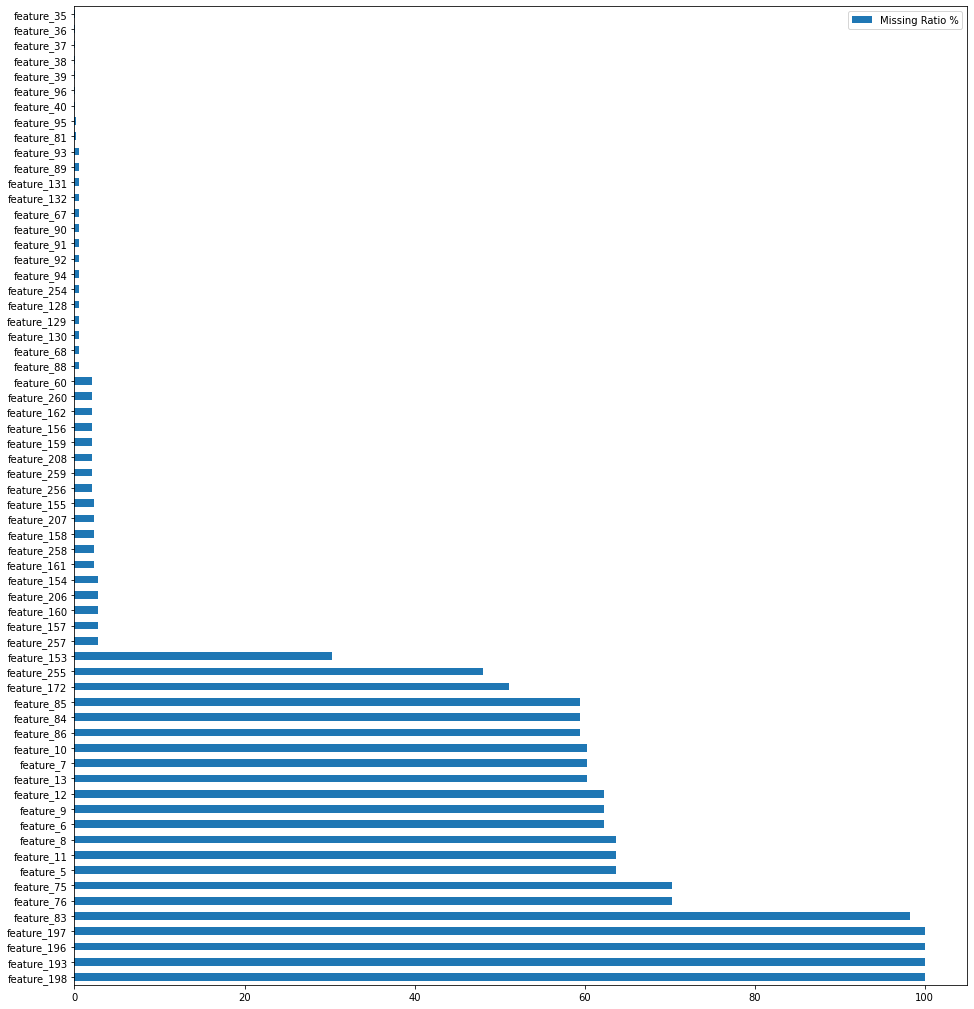

In [40]:
plot_nas(float_train)

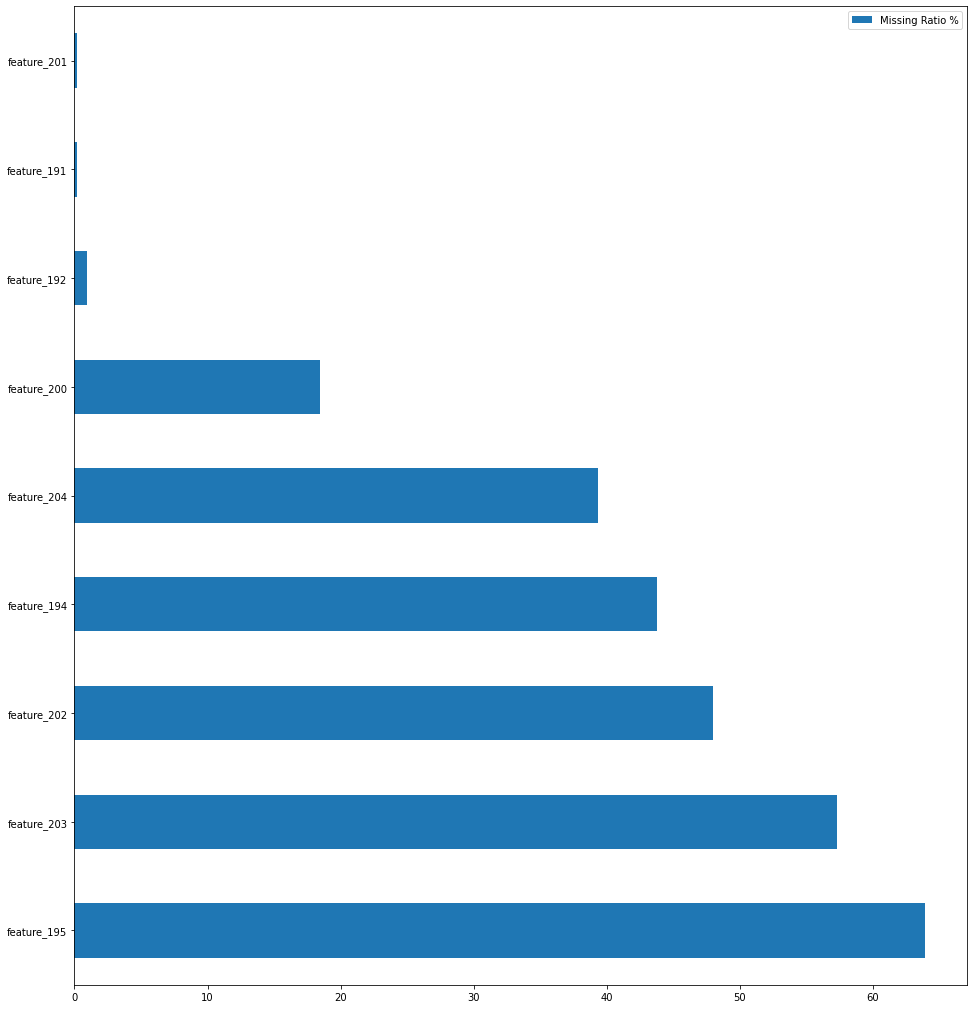

In [41]:
plot_nas(object_train)

In [42]:
int_train.describe()

,target,feature_25,feature_26,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,...,feature_497,feature_498,feature_499,feature_500,feature_501,feature_502,feature_503,feature_504,feature_505,feature_506
count,70000.000000,70000.000000,7.000000e+04,70000.000000,70000.00000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,...,70000.000000,70000.0,70000.000000,70000.0,70000.000000,70000.0,70000.000000,70000.000000,70000.0,70000.000000
mean,0.298186,7450.098014,3.764939e+04,0.677500,0.01670,0.115029,1.241786,0.008986,0.813729,0.002571,...,-3.138300,0.0,-3.138300,0.0,3.138300,0.0,3.138300,-3.138300,0.0,3.138300
std,0.457465,15596.890120,7.625716e+04,0.909453,0.12848,0.319819,0.943411,0.094367,0.915884,0.052036,...,17.344944,0.0,17.344944,0.0,17.344944,0.0,17.344944,17.344944,0.0,17.344944
min,0.000000,0.000000,0.000000e+00,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-99.000000,0.0,-99.000000,0.0,0.000000,0.0,0.000000,-99.000000,0.0,0.000000
25%,0.000000,0.000000,0.000000e+00,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000
50%,0.000000,1132.000000,8.643000e+03,0.000000,0.00000,0.000000,2.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000
75%,1.000000,8736.500000,4.432125e+04,2.000000,0.00000,0.000000,2.000000,0.000000,2.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000
max,1.000000,659989.000000,2.920932e+06,2.000000,2.00000,2.000000,2.000000,1.000000,2.000000,2.000000,...,0.000000,0.0,0.000000,0.0,99.000000,0.0,99.000000,0.000000,0.0,99.000000


In [43]:
int_train['feature_44'].value_counts()

0    68834
1     1163
2        3
Name: feature_44, dtype: int64

In [44]:
plot_nas(int_test)

No NAs found


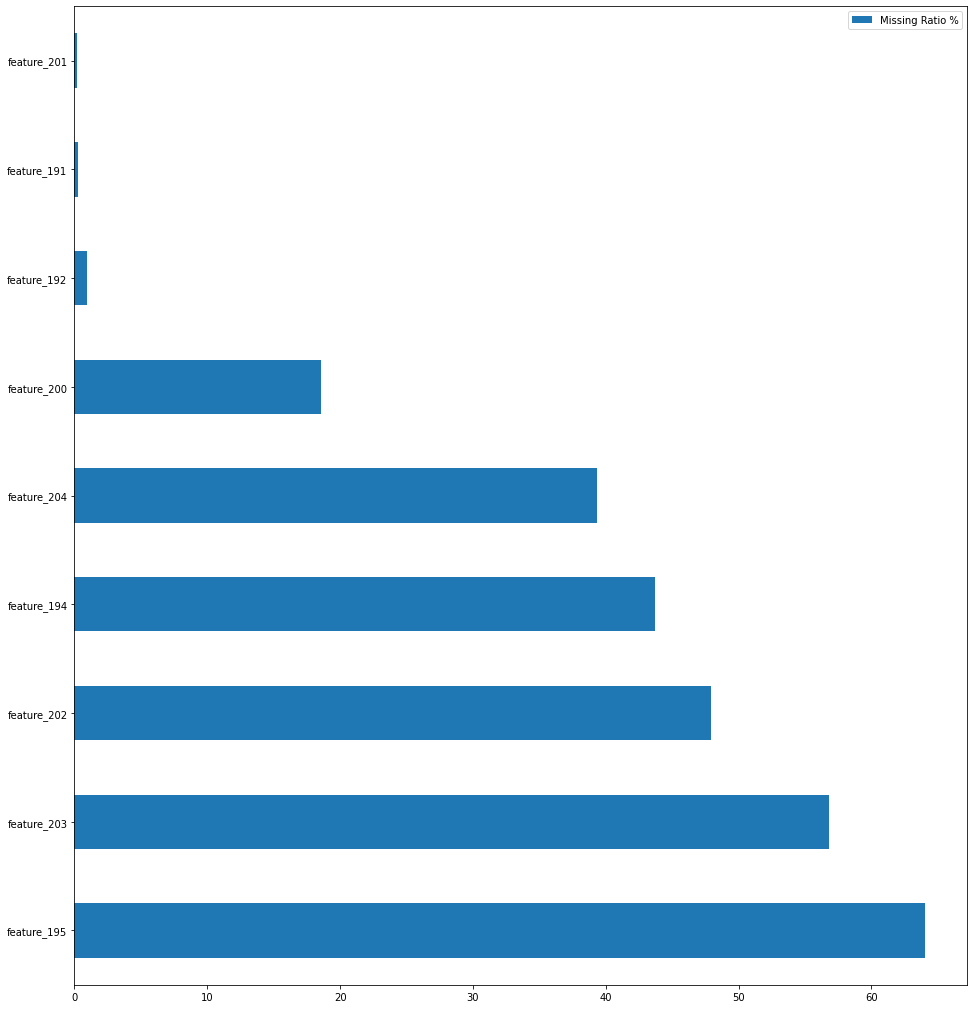

In [45]:
plot_nas(object_test)

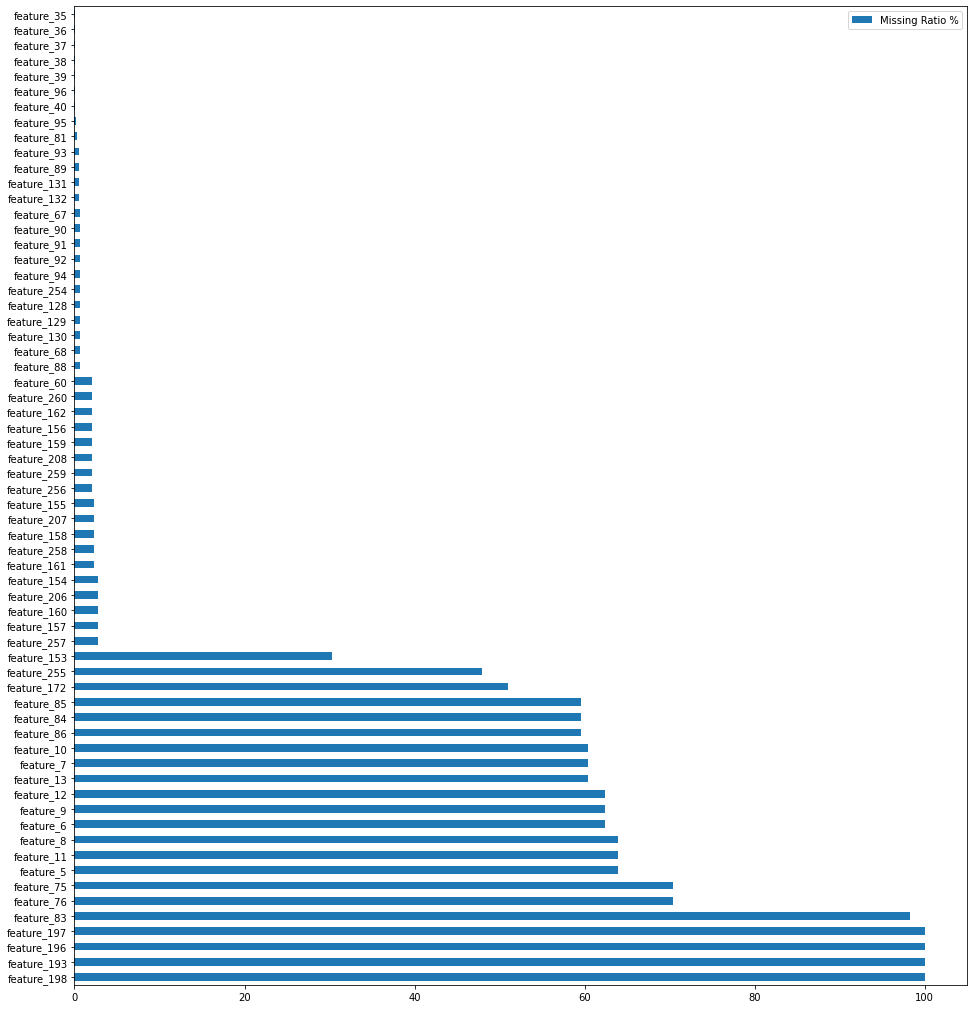

In [46]:
plot_nas(float_test)